In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import holidays
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, TimeSeriesSplit, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, make_scorer
from vacances_scolaires_france import SchoolHolidayDates
import datetime

In [214]:
# for kaggle submission
#train_data = pd.read_parquet('/kaggle/input/train-and-test/train.parquet')
#test_data = pd.read_parquet('/kaggle/input/train-and-test/final_test.parquet')

# for local tests
train_data = pd.read_parquet('train.parquet')
test_data = pd.read_parquet('final_test.parquet')

def merge_data(data):

    data = data.copy()

    # creating date column in correct format to merge datasets
    #weather_data = pd.read_csv('/kaggle/input/weather-data/weather_data_paris_daily.csv')
    
    # for local tests
    weather_data = pd.read_csv('weather_data_paris_daily.csv')
    data.loc[:, 'date'] = pd.to_datetime(data['date'])
    data.loc[:, 'date2'] = data['date'].dt.strftime('%Y-%m-%d')
    relevant_data = weather_data[['humidity', 'datetime', 'precip', 'winddir', 'icon']]
    merged_data = pd.merge(data, relevant_data, left_on='date2', right_on='datetime', how='left')

    return merged_data.drop(columns=(['date2', 'datetime']))

#curfews = [
#    ('2020-10-17', '2020-10-29', '21:00', '06:00'),
#    ('2020-10-30', '2020-12-15', '00:00', '23:59'),
#    ('2020-12-15', '2021-05-19', '18:00', '06:00'),
#    ('2021-04-03', '2021-06-20', '00:00', '23:59')
#    ]   

def is_within_lockdown_curfew(data):
    indices = []
    lockdowns = [
        ('2020-10-28', '2020-12-15'),
        ('2021-04-03', '2021-06-09')
        ] 
    curfew = [
        ('2020-12-15', '2020-04-03'),
        ] 
    for start, end in lockdowns:
        start = pd.to_datetime(start).date()
        end = pd.to_datetime(end).date()

        # Separate date and time conditions
        condition = (data['date'].dt.date >= start) & (data['date'].dt.date <= end)

        # Append indices for rows that meet the condition
        indices.extend(data[condition].index.tolist())
        data['is_lockdown'] = data.index.isin(indices).astype(int)
    
    for start, end in curfew:
        start = pd.to_datetime(start).date()
        end = pd.to_datetime(end).date()

        # Separate date and time conditions
        condition = (data['date'].dt.date >= start) & (data['date'].dt.date <= end)

        # Append indices for rows that meet the condition
        indices.extend(data[condition].index.tolist())
        data['is_curfew'] = data.index.isin(indices).astype(int)

    return data

def is_holiday(data):

    fr_holidays = holidays.France()

    data['is_bank_holiday'] = data['date'].apply(lambda x: x in fr_holidays)

    # Initialize the SchoolHolidayDates object
    school_holidays = SchoolHolidayDates()

    # Retrieve school holidays for Paris (Zone C) for the desired years
    years = [2020, 2021]
    school_holidays = SchoolHolidayDates()
    paris_holidays_2020 = school_holidays.holidays_for_year_and_zone(2020, 'C')
    paris_holidays_2021 = school_holidays.holidays_for_year_and_zone(2021, 'C')

    # Generate a list of all individual holiday dates
    holiday_dates = [holiday['date'] for holiday in paris_holidays_2020.values()]
    holiday_dates.extend([holiday['date'] for holiday in paris_holidays_2021.values()])

    # Assuming df is your existing DataFrame
    data['is_school_holiday'] = data['date'].isin(holiday_dates)

    return data

def _encode_dates(X):
    X = X.copy()  # modify a copy of X

    # Encode the date information from the "date" columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

def cyclical_encoding(data):
        
        period = np.max(data)
        sin_transform = np.sin(2 * np.pi * data / period)
        cos_transform = np.cos(2 * np.pi * data / period)
        return np.column_stack((sin_transform, cos_transform))
    
def get_estimator():
    data_merge = FunctionTransformer(merge_data)

    lockdown_dates = FunctionTransformer(is_within_lockdown_curfew)

    holiday_encoder = FunctionTransformer(is_holiday)

    date_encoder = FunctionTransformer(_encode_dates)
    date_cols = ['year', 'month', 'day']

    cycle_encoder = FunctionTransformer(cyclical_encoding)
    cycle_cols = ['hour', 'weekday']

    num_encoder = RobustScaler()
    num_cols = ['precip', 'humidity']

    categorical_encoder = OneHotEncoder(handle_unknown='ignore')
    categorical_cols = ['winddir', 'icon', 'counter_name']

    binary_cols = ['is_bank_holiday', 'is_lockdown', 'is_school_holiday', 'is_curfew']

    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ('cycle', cycle_encoder, cycle_cols),
            ('num', num_encoder, num_cols),
            ('cat', categorical_encoder, categorical_cols),
            ('binary', 'passthrough', binary_cols)
        ]
    )

    regressor = CatBoostRegressor(subsample=0.9,
                                  learning_rate=0.25421,
                                  iterations=1500,
                                  l2_leaf_reg=1,
                                  depth=8,
                                  border_count=32,
                                  rsm=0.5,
                                  bootstrap_type='Bernoulli',
                                  sampling_frequency='PerTree',
                                  verbose=0)

    pipe = make_pipeline(
        data_merge,
        lockdown_dates,
        holiday_encoder,
        date_encoder,
        preprocessor,
        regressor,
    )

    return pipe

X_train, y_train = train_data[['counter_name', 'date']], train_data[['log_bike_count']]
X_test = test_data[['counter_name', 'date']]
pipe = get_estimator()

pipe.fit(X_train, y_train)
#pred = pipe.predict(X_test)

#pred_df = pd.DataFrame({'Id': X_test.index,
#                        'log_bike_count': pred})

# for kaggle submission
#pred_df.to_csv('submission.csv', index=False)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function merge_data at 0x0000022115397A60>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function is_within_lockdown_curfew at 0x000002210B006550>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function is_holiday at 0x0000022110F343A0>)),
                ('functiontransformer-4',
                 FunctionTransfo...
                                                  FunctionTransformer(func=<function cyclical_encoding at 0x000002211538D9D0>),
                                                  ['hour', 'weekday']),
                                                 ('num', RobustScaler(),
                                                  ['precip', 'humidity']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['winddir', 'icon',
                                                   'counter_name']),
                                                 ('binary', 'passthrough',
                                                  ['is_bank_holiday',
                                                   'is_lockdown',
                                                   'is_school_holiday',
                                                   'is_curfew'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x0000022115203BB0>)])

In [212]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)

tscv = TimeSeriesSplit(n_splits=3)

cv_results = cross_validate(pipe, X_train, y_train, cv=tscv, scoring=rmse_scorer)
print(f"Average RMSE: {np.mean(cv_results['test_score']):.3f}")

Average RMSE: 0.937


In [168]:
def post_processing(pred):

    log_vals = np.sort(y_train['log_bike_count'].unique())[:10]
    range_cutoffs = [-1]
    for i in range(9):
        
        range_end = log_vals[i] + (log_vals[i+1] - log_vals[i])/2
        pred[(pred >= range_cutoffs[-1]) & (pred <= range_end)] = log_vals[i]
        range_cutoffs.append(range_end)

    return pred

def processing(pred):

    pred[(pred <= 0)] = 0

    return pred



In [211]:
pred = processing(pipe.predict(X_train))

np.sqrt(mean_squared_error(y_train, pred))

0.3509866228006335

In [165]:
pred

array([-0.18727525,  0.69314718,  0.69314718, ...,  5.25908808,
        3.36067853,  2.62205589])

In [189]:
processed_data = merge_data(X_train)
processed_data = is_within_lockdown_curfew(processed_data)
processed_data = is_holiday(processed_data)

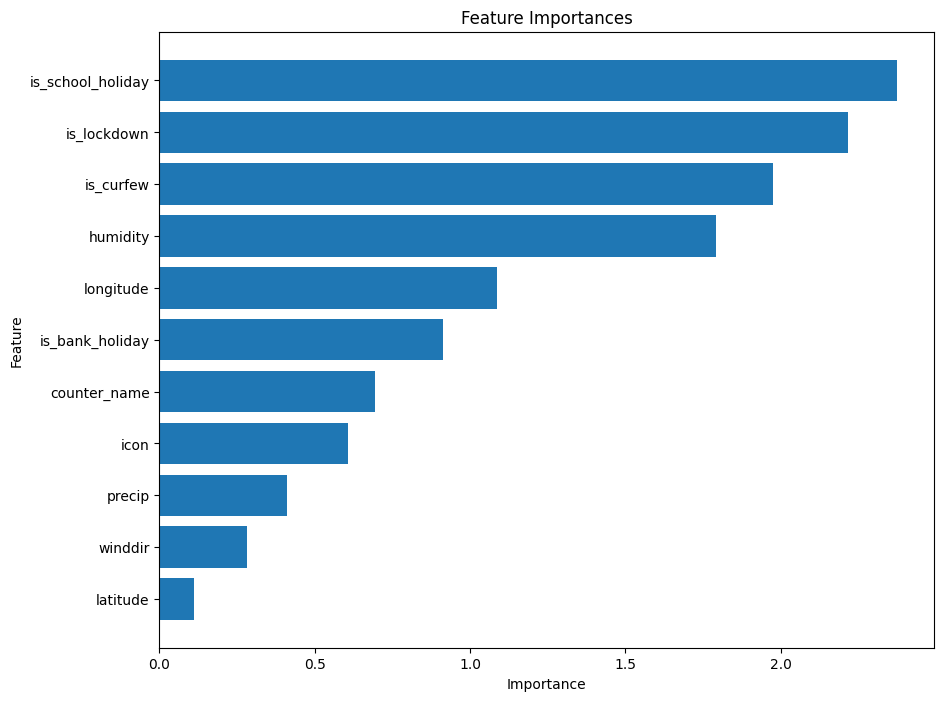

In [191]:
model = pipe.named_steps['catboostregressor']
feature_importances = model.get_feature_importance()
feature_names = processed_data.drop(columns=['date']).columns
importances = list(zip(feature_names, feature_importances))
importances.sort(key=lambda x: x[1], reverse=True)

# Splitting tuples into lists
names, values = zip(*importances)

# Creating the bar plot
plt.figure(figsize=(10, 8))
plt.barh(names, values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

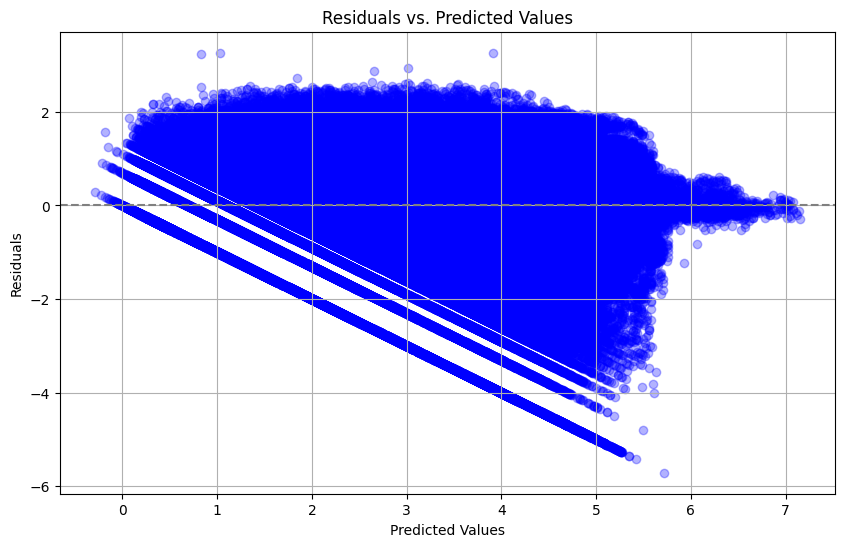

In [201]:
y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)  # cv is the number of cross-validation folds

residuals = y_train - y_pred[:, None]

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.3)
plt.axhline(y=0, color='grey', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.grid(True)
plt.show()

In [202]:
outlier_indices = np.where(np.abs(residuals) > 2)[0]
processed_data.describe()

,latitude,longitude,date,humidity,precip,winddir,is_lockdown,is_curfew
count,496827.000000,496827.000000,496827,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000
mean,48.854343,2.345479,2021-03-08 07:25:59.668858,71.489148,1.785913,183.380842,0.312354,0.312354
min,48.826360,2.265420,2020-09-01 01:00:00,39.800000,0.000000,0.100000,0.000000,0.000000
25%,48.840801,2.314440,2020-12-05 22:00:00,62.300000,0.000000,72.500000,0.000000,0.000000
50%,48.852090,2.353870,2021-03-08 11:00:00,72.900000,0.040000,210.000000,0.000000,0.000000
75%,48.864610,2.375870,2021-06-09 14:00:00,81.100000,1.782000,250.700000,1.000000,1.000000
max,48.891720,2.409690,2021-09-09 23:00:00,96.100000,32.592000,359.200000,1.000000,1.000000
std,0.018554,0.038026,NaN,12.096509,4.057558,103.064675,0.463454,0.463454


In [203]:
outlier_df = processed_data.loc[outlier_indices]
outlier_df.describe()

,latitude,longitude,date,humidity,precip,winddir,is_lockdown,is_curfew
count,18843.000000,18843.000000,18843,18843.000000,18843.000000,18843.000000,18843.000000,18843.000000
mean,48.851923,2.328819,2021-03-30 00:38:05.368571,70.110895,1.962616,181.635737,0.296715,0.296715
min,48.826360,2.265420,2020-09-01 01:00:00,39.800000,0.000000,0.100000,0.000000,0.000000
25%,48.834210,2.265420,2021-01-09 18:30:00,60.800000,0.000000,65.500000,0.000000,0.000000
50%,48.846028,2.326660,2021-04-24 14:00:00,71.000000,0.034000,210.000000,0.000000,0.000000
75%,48.863770,2.375429,2021-06-28 06:00:00,80.000000,2.135000,258.000000,1.000000,1.000000
max,48.891410,2.409690,2021-09-09 23:00:00,96.100000,32.592000,359.200000,1.000000,1.000000
std,0.018738,0.045178,NaN,11.785311,4.479893,105.138684,0.456822,0.456822


In [204]:
counts = outlier_df['counter_name'].value_counts()
counters_list = ['28 boulevard Diderot E-O', '20 Avenue de Clichy NO-SE', '20 Avenue de Clichy SE-NO']
outlier_counters_df = outlier_df[outlier_df['counter_name'].isin(counters_list)]
y_outliers = y_train.iloc[outlier_counters_df.index]
y_outliers['log_bike_count'].describe()
counts

counter_name
28 boulevard Diderot E-O                           5770
Face au 40 quai D'Issy SO-NE                       3220
Face au 40 quai D'Issy NE-SO                       1914
20 Avenue de Clichy NO-SE                          1806
20 Avenue de Clichy SE-NO                          1797
Totem 73 boulevard de Sébastopol S-N               1464
152 boulevard du Montparnasse E-O                   484
152 boulevard du Montparnasse O-E                   483
Pont des Invalides S-N                              391
Face au 70 quai de Bercy S-N                        279
Face au 4 avenue de la porte de Bagnolet O-E        188
Voie Georges Pompidou NE-SO                         166
Totem 73 boulevard de Sébastopol N-S                 95
6 rue Julia Bartet SO-NE                             91
Face au 8 avenue de la porte de Charenton NO-SE      90
Voie Georges Pompidou SO-NE                          75
Pont des Invalides N-S                               61
Face au 4 avenue de la porte de Bag

In [205]:
y_pred_outliers = y_pred[outlier_counters_df.index]
y_pred_outliers_df = pd.DataFrame({'log_bike_count': y_pred_outliers})
y_pred_outliers_df.describe()

,log_bike_count
count,9373.000000
mean,3.896832
std,0.749262
min,1.124546
25%,3.531299
50%,4.011448
75%,4.403942
max,5.628723


In [206]:
y_outliers = y_train.iloc[outlier_counters_df.index]
y_outliers.describe()

,log_bike_count
count,9373.000000
mean,0.723414
std,0.829690
min,0.000000
25%,0.000000
50%,0.693147
75%,1.386294
max,5.634790


In [207]:
y_pred_df = pd.DataFrame({'log_bike_count': y_pred})
y_pred_df.describe()

,log_bike_count
count,496827.000000
mean,3.121102
std,1.430956
min,-0.289325
25%,1.880446
50%,3.622510
75%,4.235093
max,7.146775


In [158]:
log_vals = np.sort(y_train['log_bike_count'].unique())[:10]
range_cutoffs = [log_vals[i] + (log_vals[i+1] - log_vals[i])/2 for i in range(9)]
range_cutoffs

[0.34657359027997264,
 0.8958797346140275,
 1.2424533248940002,
 1.4978661367769954,
 1.7005986908310775,
 1.868834809141684,
 2.0126758453675744,
 2.1383330595080277,
 2.2499048351651325]

In [148]:
log_vals

array([0.        , 0.69314718, 1.09861229, 1.38629436, 1.60943791,
       1.79175947, 1.94591015, 2.07944154, 2.19722458, 2.30258509])

<Axes: >

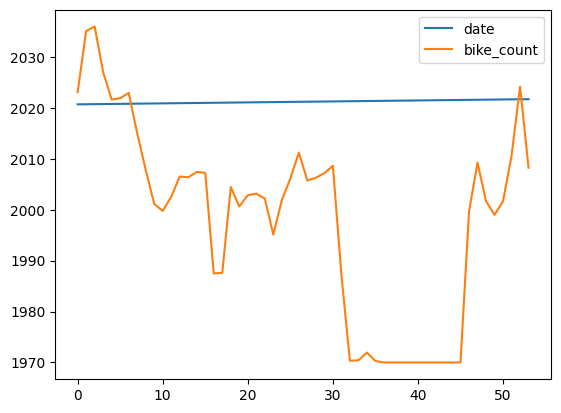

In [208]:
outlier = train_data[train_data['counter_name']=='20 Avenue de Clichy NO-SE']

outlier.groupby(pd.Grouper(freq="1w", key='date'))['bike_count'].sum().reset_index().plot()

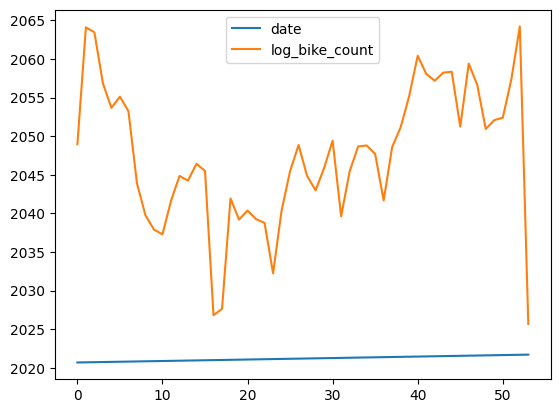

In [85]:
aggregated_df = train_data.groupby(pd.Grouper(freq="1w", key="date"))['bike_count'].sum().reset_index().plot()
